In [2]:
%load_ext autoreload
%autoreload 2
import sys 
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
%config Completer.use_jedi = False

In [3]:
(Path.cwd().parent)

PosixPath('/home/ubuntu/varios/skforecast')

In [4]:
import matplotlib.pyplot as plt
import joypy
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg

from scipy import stats

In [5]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')
data.info()

# Data preprocessing
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label ='right').mean()

# Data alteration
# ==============================================================================
rng = np.random.default_rng(seed=123)
data.loc["2012-06": "2012-09", "Demand"] = rng.normal(
                                              loc   = 3000,
                                              scale = 100,
                                              size  = len(data.loc["2012-06": "2012-09"])
                                          )

# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-10-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB
Dates train      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Dates validacion : 2014-01-01 00:00:00 --- 2014-10-31 00:00:00  (n=304)
Dates test       : 2014-11-01 00:00:00 --- 2014-12-30 00:00:00  (n=60)


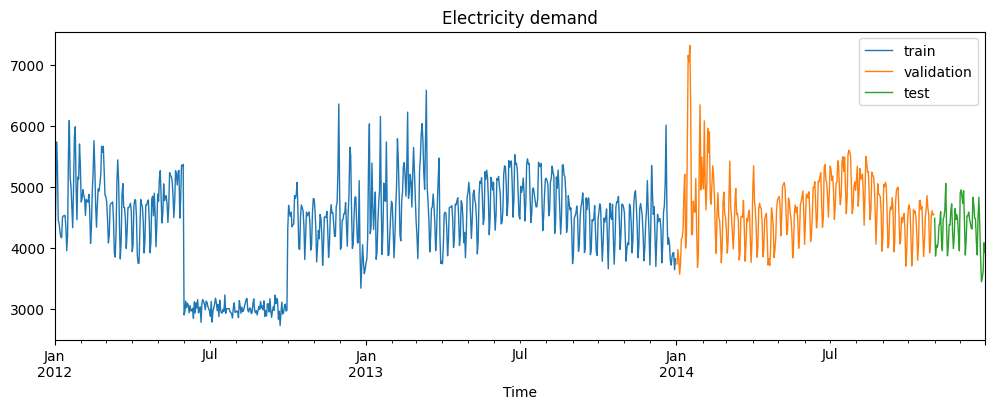

In [6]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_train.Demand.plot(ax=ax, label='train', linewidth=1)
data_val.Demand.plot(ax=ax, label='validation', linewidth=1)
data_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

In [21]:
# Create Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor    = HistGradientBoostingRegressor(random_state=123),
                 lags         = 21,
                 transformer_y=StandardScaler()
             )
forecaster.fit(y=data.Demand)
boot_samples = forecaster._boot_sampling(steps=15,  n_boot=50)

In [22]:
boot_samples_df = pd.DataFrame(boot_samples.T)
boot_samples_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.382959,1.209726,1.195610,1.229095,1.237432,1.233750,1.106705,1.064945,1.109780,1.211791,1.390559,1.227965,1.046711,1.148799,1.002598
1,1.363484,1.306885,1.332450,1.316326,1.293102,1.228614,1.059165,1.029733,1.247429,1.228553,1.268801,1.246404,1.253150,1.083698,0.883882
2,1.396481,1.338699,1.307207,1.342725,1.077879,0.813279,0.862435,1.001374,1.242941,1.240746,1.258410,0.866498,0.952107,1.168591,1.053134
3,1.440853,1.504533,1.361822,1.827715,1.379717,1.109068,0.984299,1.138790,1.339144,1.303829,1.226354,0.790305,0.950783,0.974766,0.926858
4,1.404341,1.156335,1.299547,1.249153,1.175002,1.136446,1.089132,1.059114,1.307366,1.418897,1.337910,1.170745,1.123381,1.117181,0.862108


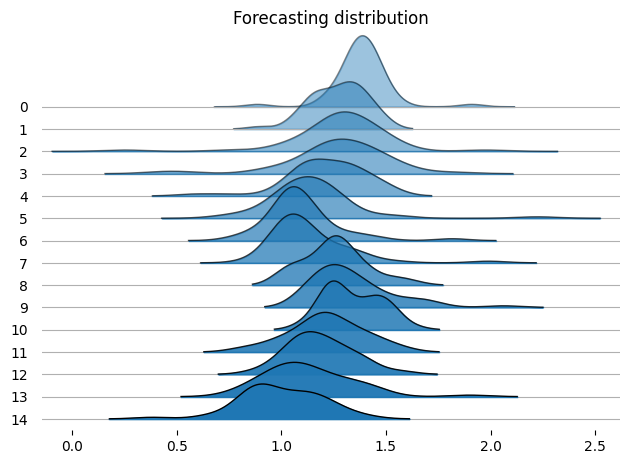

In [36]:
fig, axes = joypy.joyplot(boot_samples_df,range_style='own',grid="y",linewidth=1, legend=False, fade=True,
                          hist=False, title="Forecasting distribution")

In [9]:
forecaster.predict_dist(steps=3, distribution=stats.norm, n_boot=4)

/home/ximo/anaconda3/envs/skforecast/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu


,beta,m,loc,scale
2014-12-31,4.537034,231.062035,-2.624217,3962.218408
2015-01-01,47.281290,1.096198,-2.530897,3898.306285
2015-01-02,4.765740,15.041649,-2.704941,3831.792405
